rispetto a run 0 ho messo un learning rate diverso e ho raddoppiato il numero di epoche. il learning rate è stato diviso per 2.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np
import seaborn as sns

In order to set-up the dataset I had to download if folllowing an online procedure. 
The dataset was dismissed by torchivision and is not more available.

The directory structure should be:

└── stanford_cars 
    └── cars_test_annos_withlabels.mat 
    └── cars_train
        └── *.jpg
    └── cars_test
        └── .*jpg
    └── devkit
        ├── cars_meta.mat
        ├── cars_test_annos.mat
        ├── cars_train_annos.mat
        ├── eval_train.m
        ├── README.txt
        └── train_perfect_preds.txt

In [5]:
# Load the dataset
dataset = torchvision.datasets.StanfordCars(root="./")

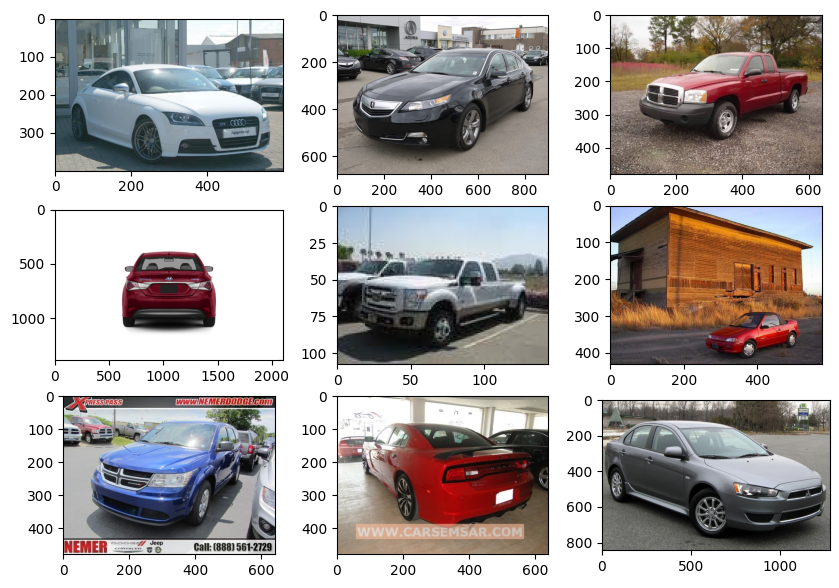

In [6]:
# Display some random images of the dataset
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(dataset[i * 3 + j][0])
        ax[i, j].axis("on")
plt.show()

In [7]:
# Define transformations for training and validation sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.StanfordCars(root="./", split='train', transform=transform_train)
val_dataset = datasets.StanfordCars(root="./", split='test', transform=transform_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

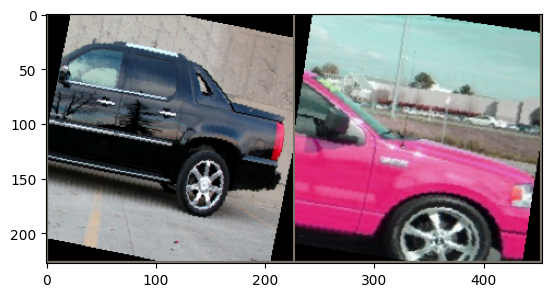

In [8]:
# Display some augmented images from the training set
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_augmented_images(dataloader):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out)

# Create a DataLoader for visualization with a small batch size
vis_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Display some augmented images
show_augmented_images(vis_loader)

In [9]:
# Load pretrained VGG19 model
model = models.vgg19(pretrained=True)

# Modify the final layer to match the number of classes in the Stanford Cars dataset
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 196)  # Stanford Cars dataset has 196 classes

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = model.to(device)

print(f"Using device: {device}")
print(f"Device: {device}")

/Users/carpanini24/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/carpanini24/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: mps
Device: mps


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
# Function to create a new run directory
def create_new_run_dir(base_log_dir):
    run_number = 0
    while os.path.exists(os.path.join(base_log_dir, f"{run_number:04d}")):
        run_number += 1
    new_run_dir = os.path.join(base_log_dir, f"{run_number:04d}")
    os.makedirs(new_run_dir)
    return new_run_dir

# Base log directory
base_log_dir = "./runs/StanfordCars/"

# Create a new run directory
log_dir = create_new_run_dir(base_log_dir)
writer = SummaryWriter(log_dir)

In [12]:
num_epochs = 50

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.float() / len(train_dataset)

    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.float() / len(val_dataset)

    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Step the scheduler
    scheduler.step()

# Close the TensorBoard writer
writer.close()

Epoch 1/50
Train Loss: 5.2519 Acc: 0.0112
Val Loss: 4.9903 Acc: 0.0328
Epoch 2/50
Train Loss: 4.8142 Acc: 0.0393
Val Loss: 3.9278 Acc: 0.1108
Epoch 3/50
Train Loss: 4.2113 Acc: 0.0850
Val Loss: 3.3184 Acc: 0.1955
Epoch 4/50
Train Loss: 3.7756 Acc: 0.1407
Val Loss: 2.7715 Acc: 0.2942
Epoch 5/50
Train Loss: 3.4040 Acc: 0.1979
Val Loss: 2.2836 Acc: 0.3971
Epoch 6/50
Train Loss: 3.1319 Acc: 0.2446
Val Loss: 2.0151 Acc: 0.4415
Epoch 7/50
Train Loss: 2.8838 Acc: 0.2949
Val Loss: 1.8986 Acc: 0.4814
Epoch 8/50
Train Loss: 2.4715 Acc: 0.3719
Val Loss: 1.4881 Acc: 0.5813
Epoch 9/50
Train Loss: 2.3873 Acc: 0.3951
Val Loss: 1.4304 Acc: 0.5932
Epoch 10/50
Train Loss: 2.3195 Acc: 0.3993
Val Loss: 1.3937 Acc: 0.6039
Epoch 11/50
Train Loss: 2.3054 Acc: 0.4121
Val Loss: 1.3875 Acc: 0.6027
Epoch 12/50
Train Loss: 2.2334 Acc: 0.4169
Val Loss: 1.3653 Acc: 0.6109
Epoch 13/50
Train Loss: 2.2321 Acc: 0.4271
Val Loss: 1.3057 Acc: 0.6273
Epoch 14/50
Train Loss: 2.2103 Acc: 0.4347
Val Loss: 1.3015 Acc: 0.6247
E

In [19]:
torch.save(model.state_dict(), 'trained_model4.pth')

In [14]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

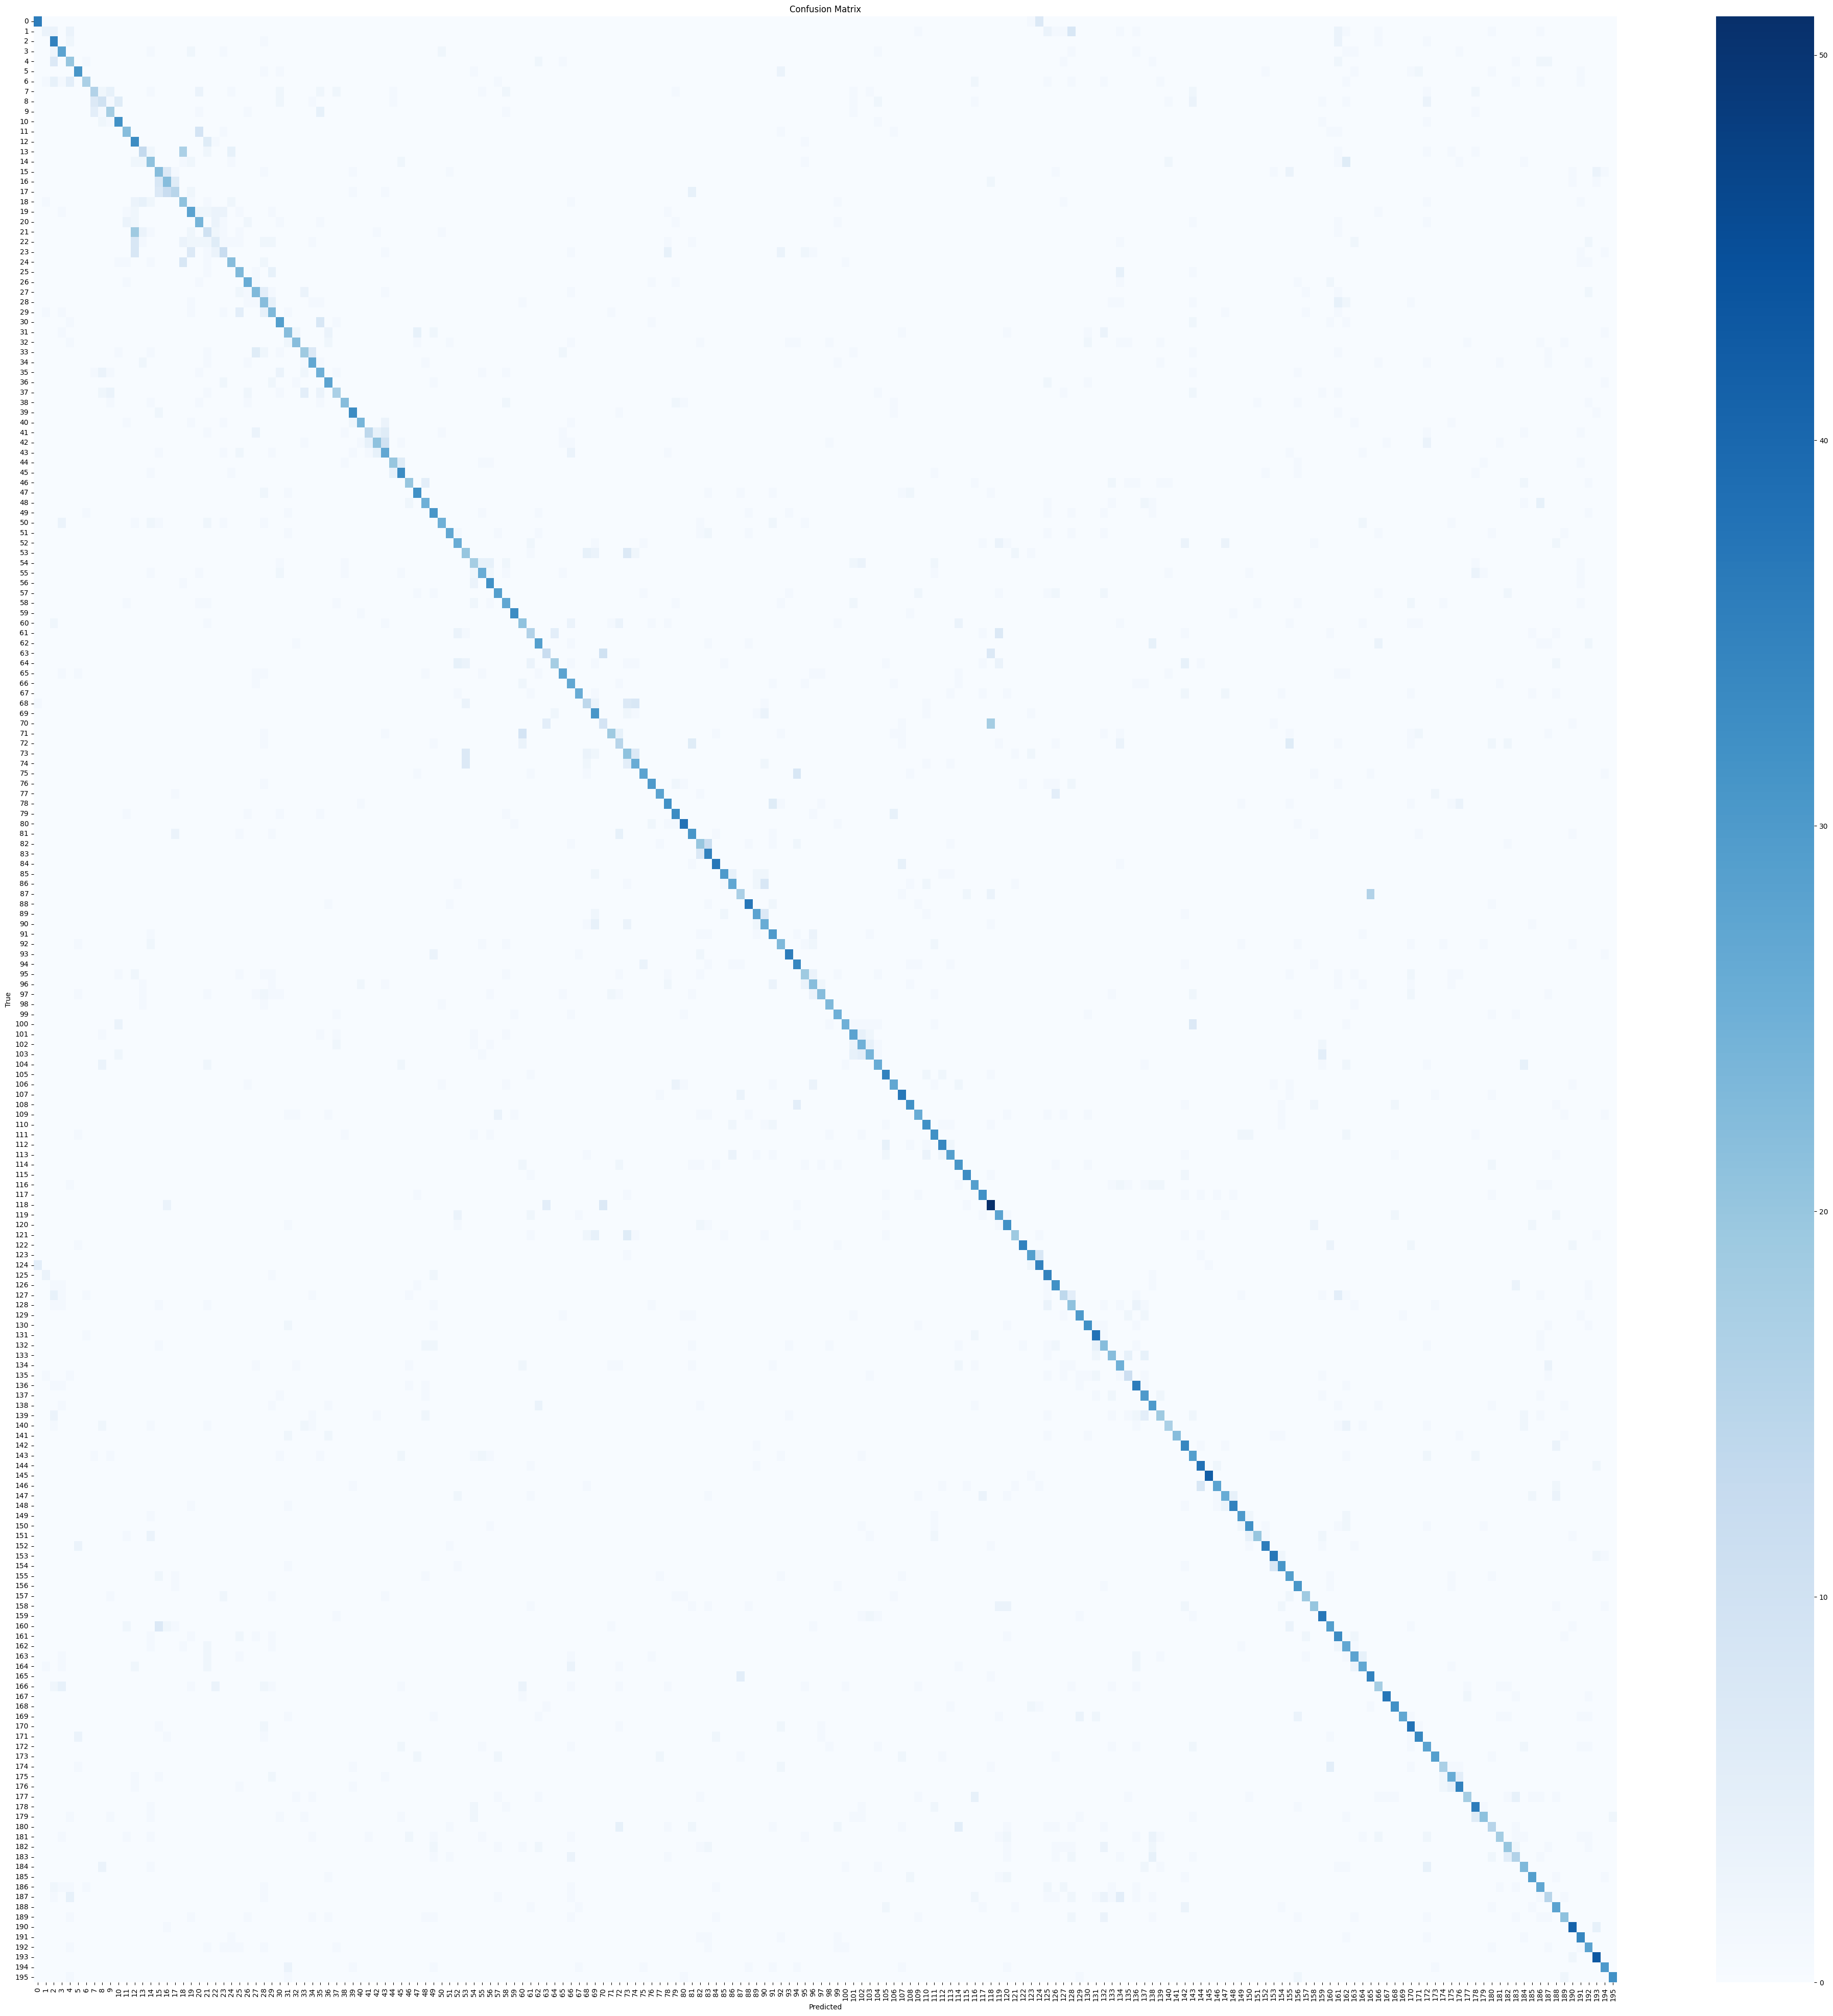

In [16]:
# Plot the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=range(196), yticklabels=range(196))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of validation data
inputs, labels = next(iter(val_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Forward pass to get predictions
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Define a list of class names if available
class_names = [str(i) for i in range(196)]  # Modify this with actual class names if available

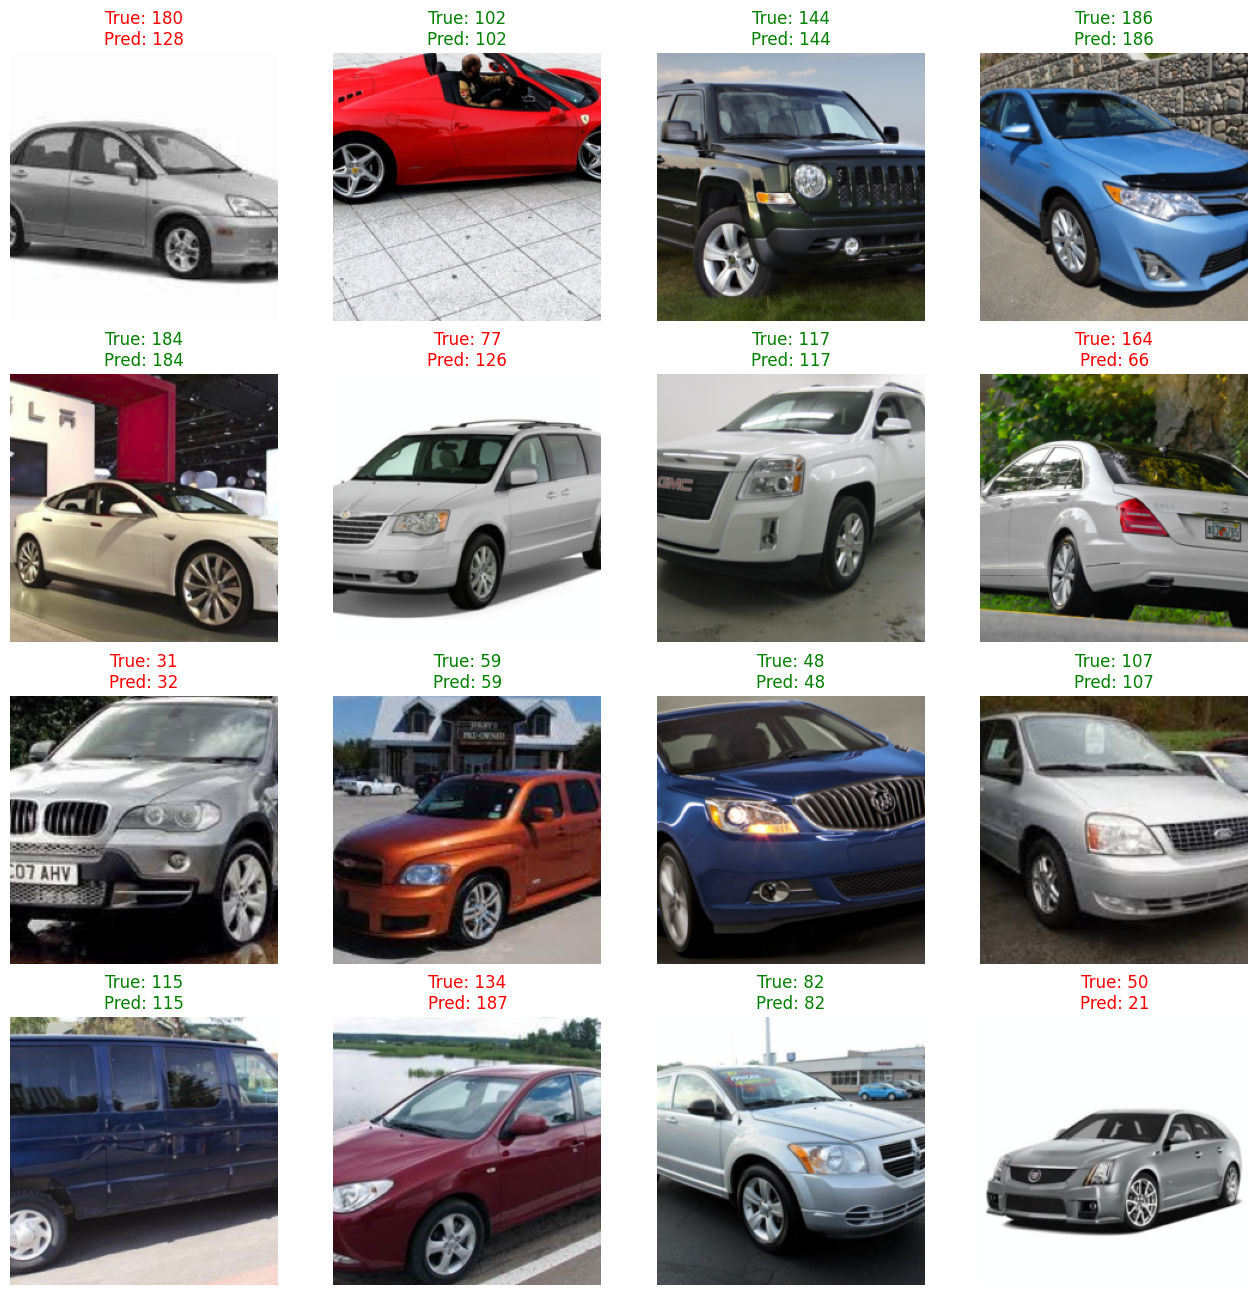

In [18]:
# Display images with predictions and true labels
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    imshow(inputs.cpu().data[i])
    true_label = class_names[labels[i].item()] if class_names else labels[i].item()
    pred_label = class_names[preds[i].item()] if class_names else preds[i].item()
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=("green" if true_label == pred_label else "red"))
    ax.axis('off')

plt.show()